<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Match_Dominance_Metrics_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


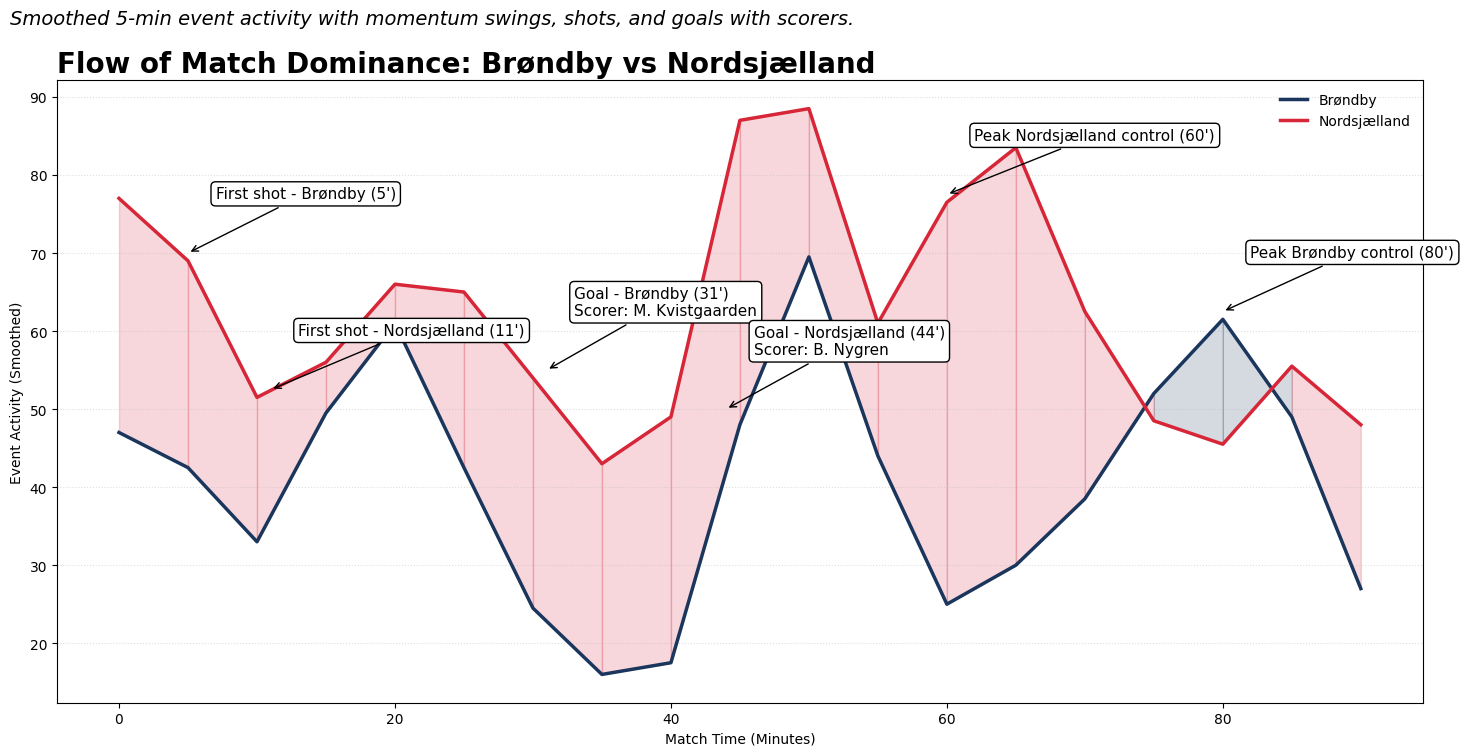

In [3]:
# --- Brøndby vs Nordsjælland Match Dominance Analysis ---

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/Recruitment/Brøndby 1-1 Nordsjælland.csv'
df = pd.read_csv(file_path)

# Add timestamp and time_bin
df['timestamp'] = df['timeMin'] * 60 + df['timeSec']
df['time_bin'] = (df['timestamp'] // 300).astype(int)

# Map teams
team_map = {
    '9qsmopgutr7ut5g6workk8w4i': 'Brøndby',
    '77tfx9me4aaqhzv78bmgsy9bg': 'Nordsjælland'
}
df['team'] = df['contestantId'].map(team_map)

# Calculate dominance
dominance = df.groupby(['time_bin', 'team']).size().unstack(fill_value=0)
dominance['dominance_score'] = dominance['Brøndby'] - dominance['Nordsjælland']
dominance['Brøndby_smooth'] = dominance['Brøndby'].rolling(2, min_periods=1).mean()
dominance['Nordsjælland_smooth'] = dominance['Nordsjælland'].rolling(2, min_periods=1).mean()
time_labels = dominance.index * 5

# First shots
shot_events = df[df['typeId'].isin([13, 14, 15, 16])]
first_shots = shot_events.groupby('team')['timestamp'].min().reset_index()
first_shots['minute'] = (first_shots['timestamp'] // 60).astype(int)
first_shots['time_bin'] = (first_shots['timestamp'] // 300).astype(int)

# Goals
goal_events = df[(df['typeId'] == 16) | (df['qualifier/14/value'] == 'Goal')].copy()

# Prepare Annotations
annotations = []

# Peak dominance
max_idx = dominance['dominance_score'].idxmax()
min_idx = dominance['dominance_score'].idxmin()
annotations.append({
    'minute': time_labels[max_idx],
    'label': f"Peak Brøndby control ({int(time_labels[max_idx])}')",
    'y': max(dominance.iloc[max_idx][['Brøndby_smooth', 'Nordsjælland_smooth']])
})
annotations.append({
    'minute': time_labels[min_idx],
    'label': f"Peak Nordsjælland control ({int(time_labels[min_idx])}')",
    'y': max(dominance.iloc[min_idx][['Brøndby_smooth', 'Nordsjælland_smooth']])
})

# First shots
for _, row in first_shots.iterrows():
    team = row['team']
    minute = row['minute']
    bin_idx = row['time_bin']
    y_val = max(dominance.iloc[bin_idx][['Brøndby_smooth', 'Nordsjælland_smooth']])
    annotations.append({'minute': minute, 'label': f"First shot - {team} ({minute}')", 'y': y_val})

# Goals
for _, row in goal_events.iterrows():
    team = row['team']
    player = row.get('playerName', 'Unknown Player')
    minute = int(row['timestamp'] // 60)
    bin_idx = int(row['timestamp'] // 300)
    y_val = max(dominance.iloc[bin_idx][['Brøndby_smooth', 'Nordsjælland_smooth']])
    annotations.append({'minute': minute, 'label': f"Goal - {team} ({minute}')\nScorer: {player}", 'y': y_val})

# Plot
plt.figure(figsize=(15, 8))
plt.plot(time_labels, dominance['Brøndby_smooth'], label='Brøndby', color='#1B365D', linewidth=2.5)
plt.plot(time_labels, dominance['Nordsjælland_smooth'], label='Nordsjælland', color='#D72638', linewidth=2.5)

for i in range(len(time_labels) - 1):
    x_vals = [time_labels[i], time_labels[i+1]]
    y1_b, y2_b = dominance['Brøndby_smooth'].iloc[i:i+2]
    y1_n, y2_n = dominance['Nordsjælland_smooth'].iloc[i:i+2]
    color = '#1B365D' if (y1_b - y1_n) >= 0 else '#D72638'
    plt.fill_between(x_vals, [y1_b, y2_b], [y1_n, y2_n], color=color, alpha=0.18)

for ann in annotations:
    plt.annotate(
        ann['label'],
        xy=(ann['minute'], ann['y'] + 1),
        xytext=(ann['minute'] + 2, ann['y'] + 8),
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'),
        arrowprops=dict(facecolor='black', arrowstyle='->', lw=1),
        fontsize=11
    )

plt.title("Flow of Match Dominance: Brøndby vs Nordsjælland", fontsize=20, weight='bold', loc='left')
plt.suptitle("Smoothed 5-min event activity with momentum swings, shots, and goals with scorers.",
             fontsize=14, style='italic', x=0.01, ha='left', y=0.94)
plt.xlabel("Match Time (Minutes)")
plt.ylabel("Event Activity (Smoothed)")
plt.grid(axis='y', linestyle=':', alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('/content/drive/MyDrive/Recruitment/match_dominance.png')
plt.show()

# --- Pass Chains (Brøndby) ---
brondby_id = '9qsmopgutr7ut5g6workk8w4i'
passes = df[(df['contestantId'] == brondby_id) & (df['typeId'] == 1)]
passes = passes[['timeMin', 'timeSec', 'playerId', 'playerName', 'x', 'y', 'outcome', 'eventId']]
passes['timestamp'] = passes['timeMin'] * 60 + passes['timeSec']
passes = passes.sort_values(by='timestamp').reset_index(drop=True)

chains = []
chain = []

for i, row in passes.iterrows():
    if i == 0:
        chain.append(row)
        continue
    prev = passes.iloc[i - 1]
    if row['outcome'] == 1 and (row['timestamp'] - prev['timestamp'] <= 10):
        chain.append(row)
    else:
        if len(chain) > 1:
            chains.append(chain)
        chain = [row]

if len(chain) > 1:
    chains.append(chain)

# Save chain summaries
chain_data = []
for ch in chains:
    start = ch[0]['timestamp']
    end = ch[-1]['timestamp']
    length = len(ch)
    players = [r['playerName'] for r in ch]
    chain_data.append({
        'Start Time': start,
        'End Time': end,
        'Chain Length': length,
        'Players': ' → '.join(players)
    })

chains_df = pd.DataFrame(chain_data)
chains_df.to_excel('/content/drive/MyDrive/Recruitment/pass_chains.xlsx', index=False)
